In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro 
from numpyro.infer import NUTS, MCMC
import pandas as pd
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

Now let's make some mock data.  We draw $A_0 \sim N(0,1)$, and $A_1 = A_0 + 0.5 + 0.2 * N(0,1)$, and $A_2 = A_0 - 0.2 + 0.5*N(0,1)$, subject to the edge constraint.  Thus 
$$
\Sigma = \begin{pmatrix}
1 & 1 & 1 \\
1 & 1.04 & 1 \\
1 & 1 & 1.25
\end{pmatrix}
$$

Our background distribution is considerably wider.

In [35]:
Nfg = 2000
Nbg = 250
N = Nfg+Nbg
Nband = 3

c = np.array([-0.2, 0.2])
w = np.array([1-c[0], c[0]-c[1], c[1]])

c_mu = c
c_sigma = 0.01*np.ones_like(c_mu)

sigma_obs = np.array([0.2, 0.2, 0.2])[None,:]*np.ones((N, Nband))
mu_fg = np.array([0.25, 0.5, -0.2])
mu_bg = np.zeros(3)

cov_fg = np.array([[1.0, 1.0, 1.0], [1.0, 1.04, 1.0], [1.0, 1.0, 1.25]])
scale_fg = np.sqrt(np.diag(cov_fg))
cov_bg = np.array([[4.0, 4.0, 4.0], [4.0, 8.0, 8.0], [4.0, 8.0, 12.0]])
scale_bg = np.sqrt(np.diag(cov_bg))

corr_fg = cov_fg / (scale_fg[:,None]*scale_fg[None,:])
corr_bg = cov_bg / (scale_bg[:,None]*scale_bg[None,:])

chol_corr_fg = np.linalg.cholesky(corr_fg)
chol_corr_bg = np.linalg.cholesky(corr_bg)

c_centered = np.array([mu_fg[1]-mu_fg[0], mu_fg[2]-mu_fg[1]])
edge_centered = mu_fg[0] - 0.5
e_mu = edge_centered
e_sigma = 0.1

Aobs = []
nf = 0
while nf < Nfg:
    A = np.random.multivariate_normal(mu_fg, cov_fg)
    e = A[0] + np.dot(c, (A[1:] - A[:-1] - c_centered))
    if e < edge_centered:
        pass
    else:
        Ao = A + sigma_obs[nf,:]*np.random.randn(Nband)
        Aobs.append(Ao)
        nf += 1

for i in range(Nbg):
     Aobs.append(np.random.multivariate_normal(mu_bg, cov_bg + np.diag(sigma_obs[Nfg+i,:]*sigma_obs[Nfg+i,:])))
Aobs = np.array(Aobs)
    

Now we implement a selection cut.

In [36]:
A0_cut = mu_fg[0] + 1.5
sel_mask = Aobs[:,0] < A0_cut

Aobs = Aobs[sel_mask,:]
sigma_obs = sigma_obs[sel_mask, :]

Nbg = sum(sel_mask[Nfg:])
Nfg = sum(sel_mask[:Nfg])
N = Nfg+Nbg

The foreground component, and the "edge" is clearly visible in the below corner plot:

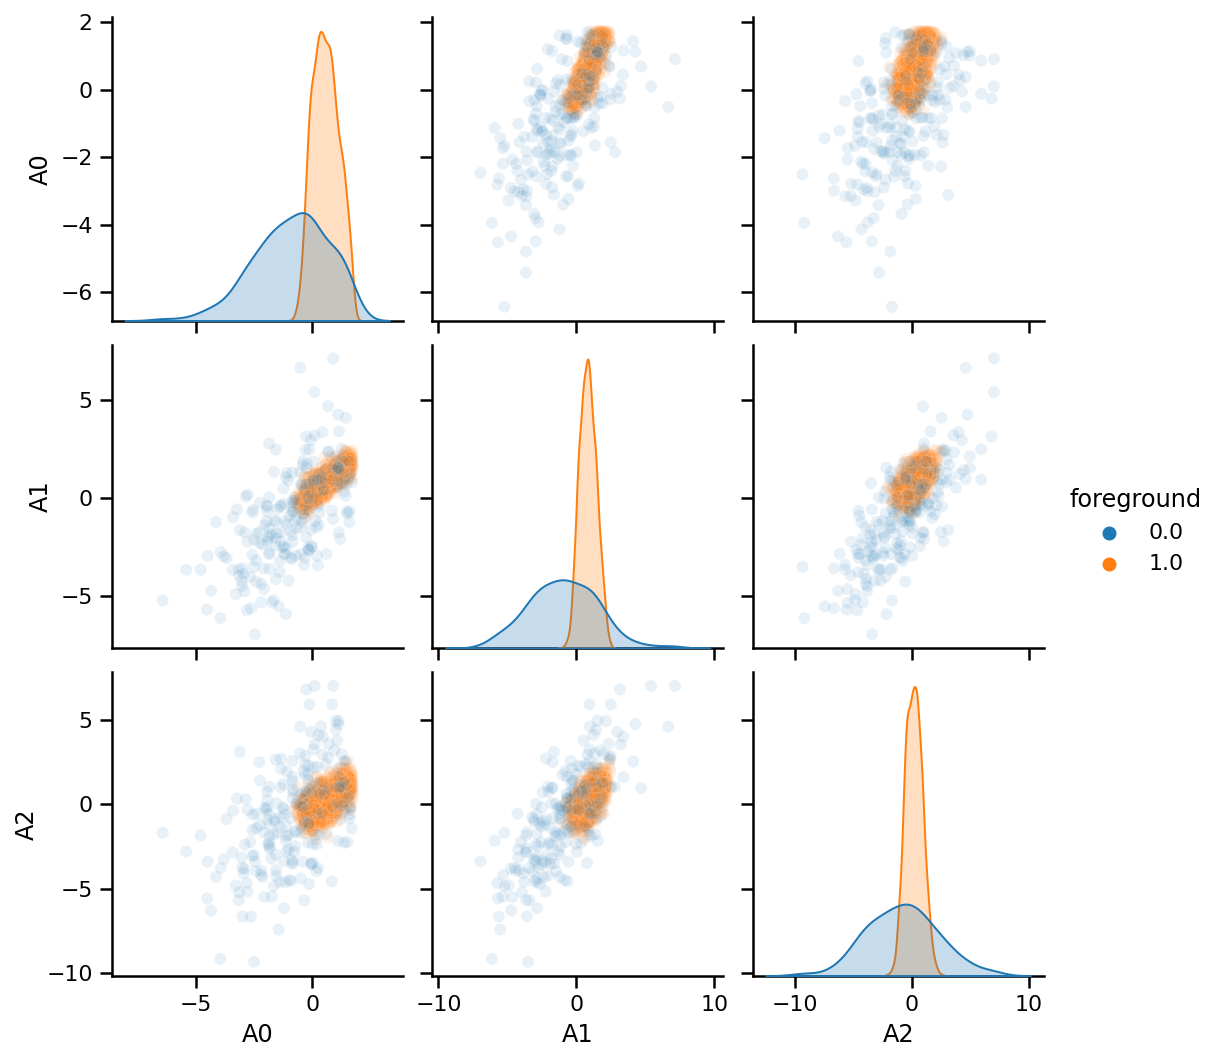

In [37]:
df = pd.DataFrame(Aobs, columns=['A0', 'A1', 'A2'])
df['foreground'] = np.concatenate((np.ones(Nfg), np.zeros(Nbg)))
#sns.pairplot(df.loc[df['foreground']==1], diag_kws={'common_norm': False})
sns.pairplot(df, hue='foreground', diag_kws={'common_norm': False}, plot_kws={'alpha': 0.1})

Zooming in on the $A_0$ photometry:

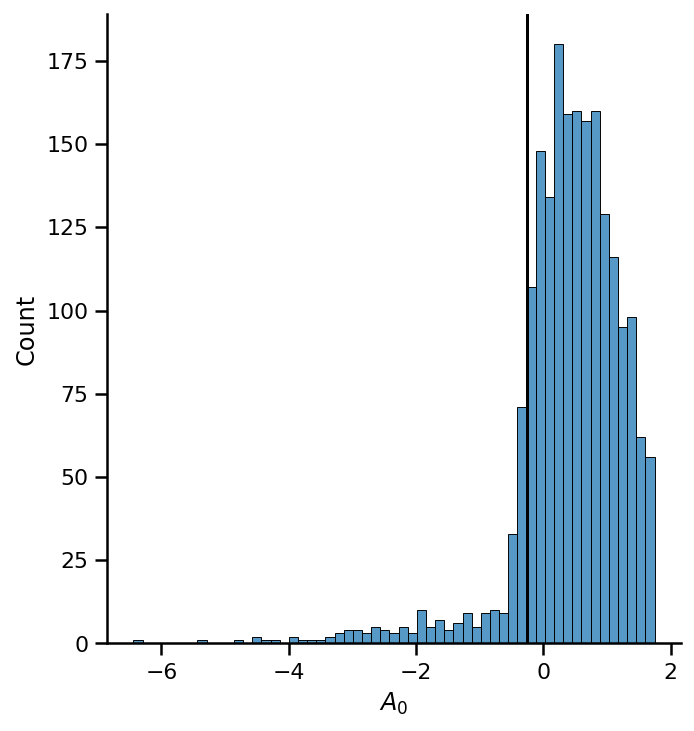

In [38]:
sns.displot(Aobs[:,0])
plt.xlabel(r'$A_0$')
plt.axvline(edge_centered, color='k')

And the "rectified" (i.e. "color corrected") $A_0$ photometry, which shows a bit sharper edge:

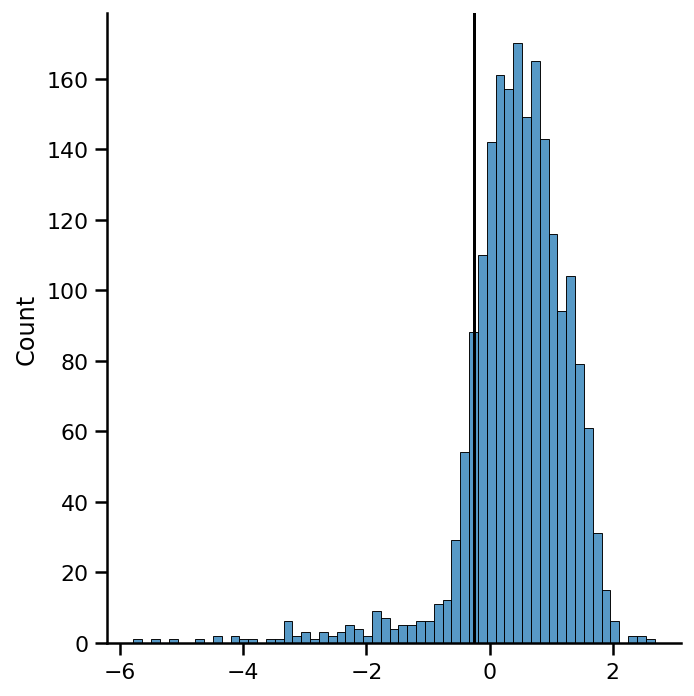

In [39]:
eobs = Aobs[:, 0] + np.dot((Aobs[:, 1:]-Aobs[:, :-1] - c_centered[None,:]), c)
sigma_eobs = np.sqrt(np.sum(w[None,:]*w[None,:]*sigma_obs*sigma_obs, axis=1))
mu_e = np.dot(w, mu_fg)
sigma_e = np.sqrt(np.dot(w, np.dot(cov_fg, w)))

sns.displot(eobs)
plt.axvline(edge_centered, color='k')

In [40]:
num_chains=4
thin=1

sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_warmup=thin*1000, num_samples=thin*1000, thinning=thin, num_chains=num_chains)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, A0_cut, e_center_mu=e_mu, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, c_center=c_centered)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

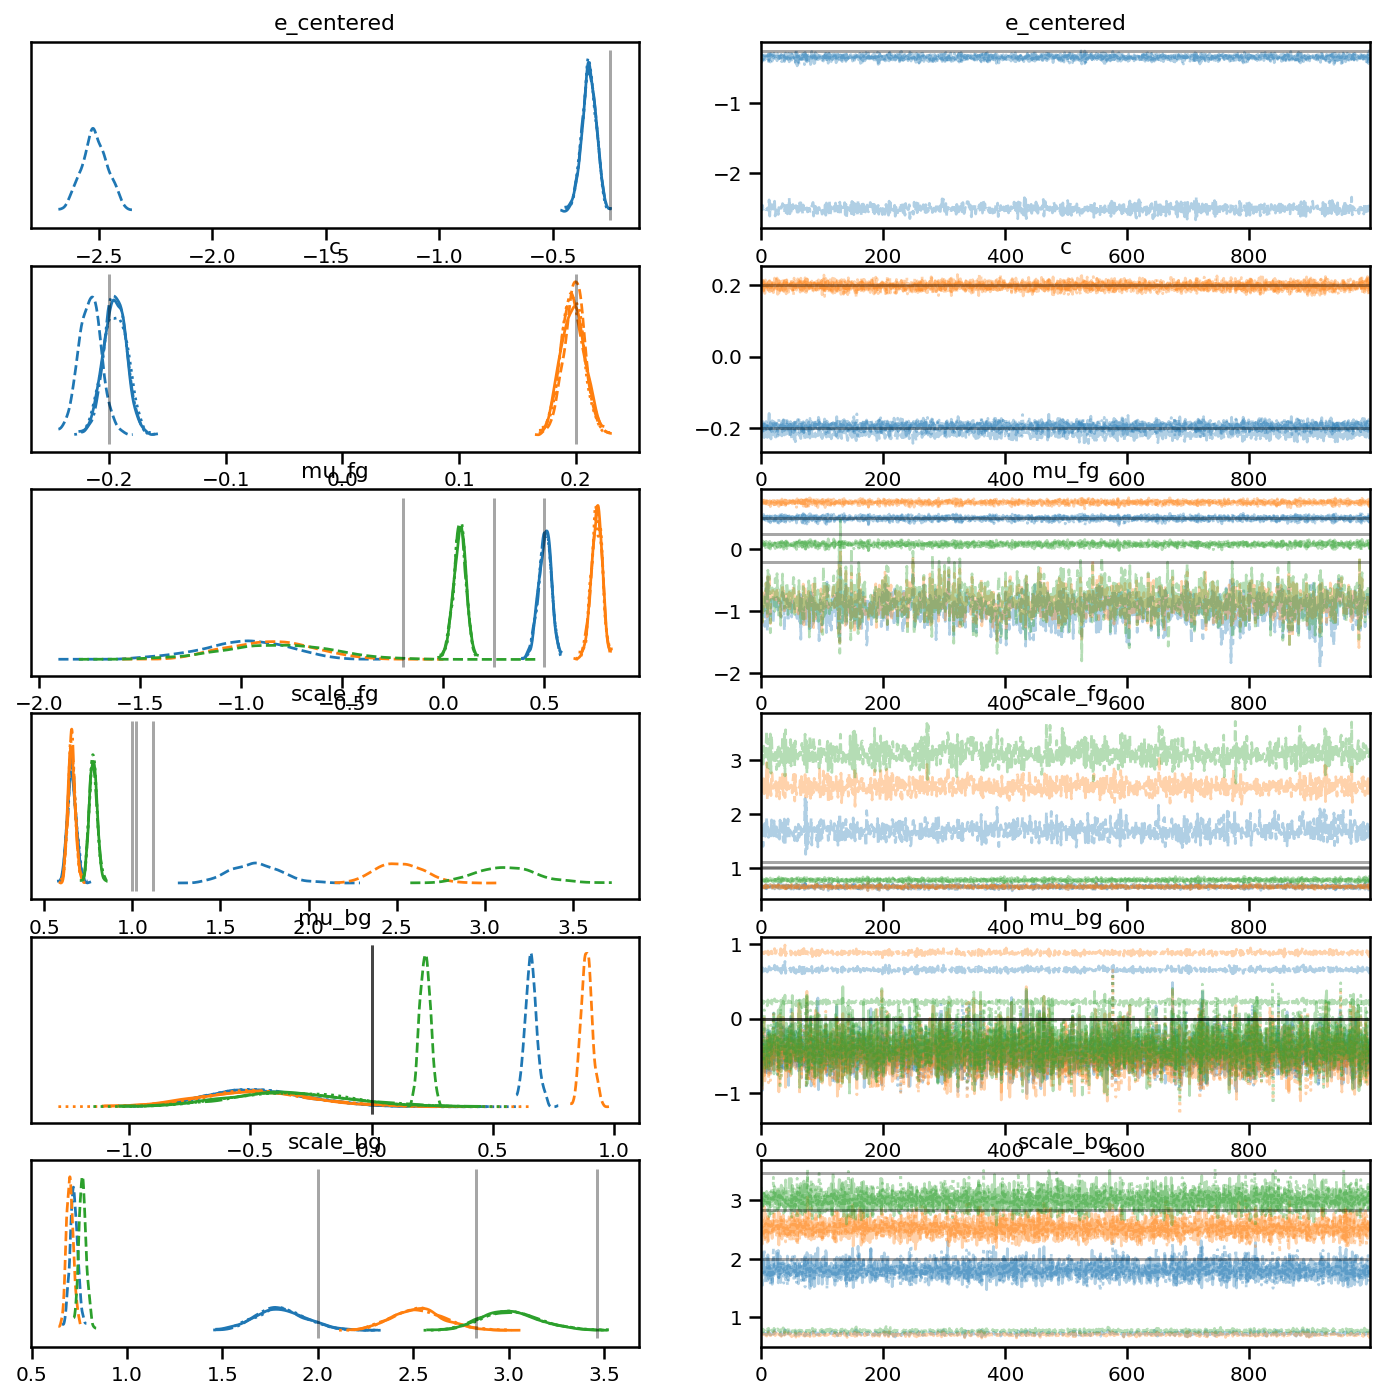

In [41]:
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e_centered', {}, edge_centered), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)])

In [42]:
trace.posterior.e_centered.mean(axis=1)

<xarray.DataArray 'e_centered' (chain: 4)>
array([-0.34102572, -0.34195106, -2.5172037 , -0.34108378])
Coordinates:
  * chain    (chain) int64 0 1 2 3

Looks like initialization is still an issue, so the cell below is set up to exclude some chains that have gone wrong.  Edit the `good_chains` variable to point to the indices of the chains that are OK.

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

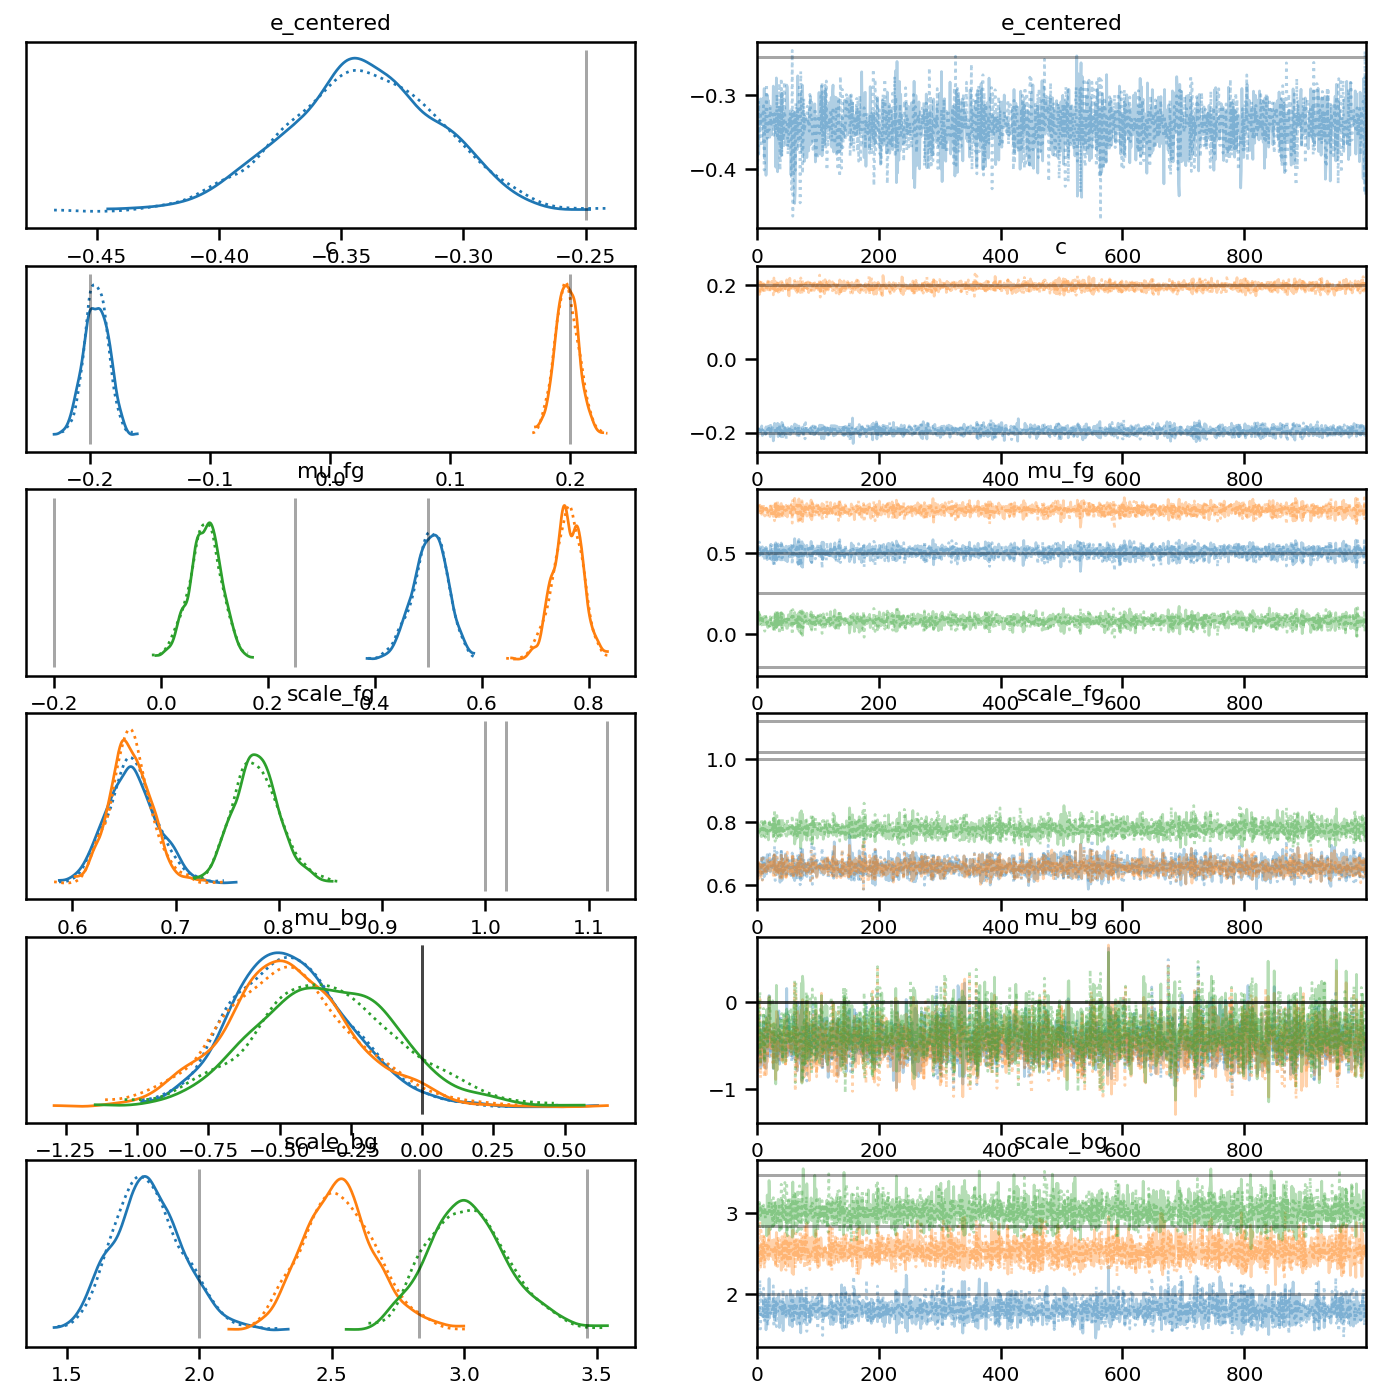

In [43]:
good_chains=[1,3]
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('mu_fg', {}, mu_fg), ('e_centered', {}, edge_centered), ('c', {}, c), ('scale_fg', {}, scale_fg), ('mu_bg', {}, mu_bg), ('scale_bg', {}, scale_bg)],
              coords={'chain': good_chains})

In [44]:
trace = az.from_numpyro(mcmc)
az.summary(trace, var_names=['e_centered', 'c','mu_fg', 'cov_fg', 'mu_bg', 'cov_bg'], coords={'chain': good_chains})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e_centered,-0.342,0.032,-0.402,-0.285,0.001,0.000,3337.0,1534.0,1.0
c[0],-0.195,0.010,-0.213,-0.176,0.000,0.000,4564.0,1572.0,1.0
c[1],0.197,0.010,0.179,0.216,0.000,0.000,3705.0,1458.0,1.0
mu_fg[0],0.503,0.032,0.443,0.561,0.001,0.000,3693.0,1413.0,1.0
mu_fg[1],0.760,0.027,0.704,0.807,0.000,0.000,3630.0,1470.0,1.0
mu_fg[2],0.082,0.030,0.025,0.137,0.001,0.000,3505.0,1574.0,1.0
"cov_fg[0, 0]",0.434,0.032,0.379,0.496,0.001,0.000,4280.0,1833.0,1.0
"cov_fg[0, 1]",0.413,0.028,0.362,0.467,0.000,0.000,4006.0,1589.0,1.0
"cov_fg[0, 2]",0.396,0.031,0.343,0.458,0.001,0.000,3717.0,1609.0,1.0
"cov_fg[1, 0]",0.413,0.028,0.362,0.467,0.000,0.000,4006.0,1589.0,1.0


Text(0.5, 0, '$A_1 - A_0$')

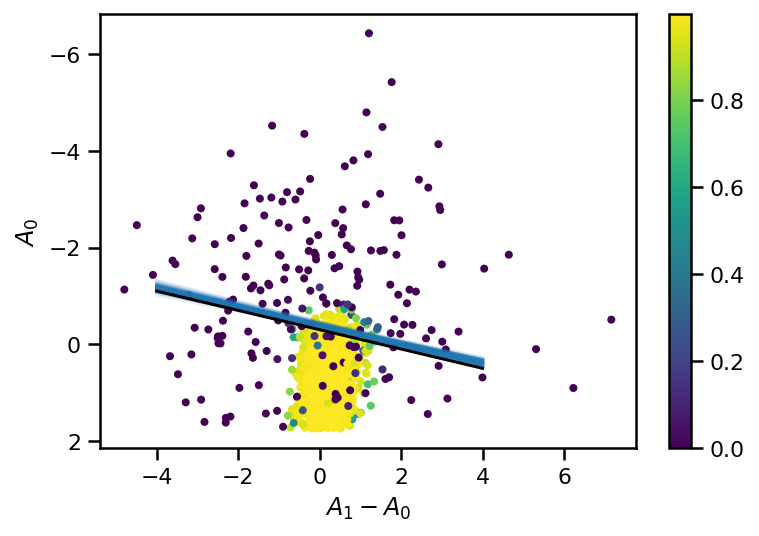

In [45]:
plt.scatter(Aobs[:,1]-Aobs[:,0], Aobs[:,0], c=np.exp(trace.posterior.log_fg_prob[good_chains,:,:].mean(axis=(0,1))), marker='.')
yl, yh = plt.ylim()
plt.ylim(yh, yl)
plt.colorbar()

cs = np.linspace(-4, 4, 1024)
for _ in range(100):
    c = np.random.choice(good_chains)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(cs, trace.posterior.e_centered[c,d].values - trace.posterior.c[c,d,0].values*(cs - c_centered[0]), color=sns.color_palette()[0], alpha=0.1)
plt.plot(cs, edge_centered - c_mu[0]*(cs-c_centered[0]), color='k')
plt.ylabel(r'$A_0$')
plt.xlabel(r'$A_1 - A_0$')